# Steam Games Analysis

In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np
from datetime import datetime, timedelta
import re
import string
from collections import Counter, defaultdict
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams
import nltk
nltk.download('punkt')
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

sns.set()
custom_palette = {1: 'mediumseagreen', -1: 'indianred'}
color_default = 'darkorange'

pd.set_option('display.max_colwidth', 200)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wojwo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wojwo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Overview

In [2]:
data_raw = pd.read_csv('../games.csv', usecols=['Name', 'Release date', 'Estimated owners', 'Required age', 'Price', 'Median playtime forever', 'DLC count', 'About the game', 'Supported languages', 'Full audio languages', 'Windows', 'Mac', 'Linux', 'User score', 'Positive', 'Negative', 'Achievements', 'Notes', 'Developers', 'Publishers', 'Categories', 'Genres', 'Tags'])

In [3]:
data_raw.head()

Name  Release date Estimated owners  Required age  Price  \
0       Galactic Bowling  Oct 21, 2008        0 - 20000             0  19.99   
1           Train Bandit  Oct 12, 2017        0 - 20000             0   0.99   
2           Jolt Project  Nov 17, 2021        0 - 20000             0   4.99   
3               Henosis™  Jul 23, 2020        0 - 20000             0   5.99   
4  Two Weeks in Painland   Feb 3, 2020        0 - 20000             0   0.00   

   DLC count  \
0          0   
1          0   
2          0   
3          0   
4          0   

                                                                                                                                                                                            About the game  \
0  Galactic Bowling is an exaggerated and stylized bowling game with an intergalactic twist. Players will engage in fast-paced single and multi-player competition while being submerged in a unique ne...   
1  THE LAW!! Looks to be a showdown atop a train. This will be your last fight. Good luck, Train Bandit. WHAT IS THIS GAME? Train Bandit is a simple score attack game. The Law will attack you from bo...   
2  Jolt Project: The army now has a new robotics project, jolt. It's up to you to control it and ensure the success of the missions! There are 9 stages of taking the breath away with the right diffic...   
3  HENOSIS™ is a mysterious 2D Platform Puzzler where players are propelled into weird and visceral worlds as they take control of a small, droplet of water while overcoming obstacles and enemies thr...   
4  ABOUT THE GAME Play as a hacker who has arranged a deal with a gangster. That’s how the protagonist, Jack, is assigned a mission that should be accomplished in a specific timeframe, which he will ...   

                                                                                                                                         Supported languages  \
0                                                                                                                                                ['English']   
1   ['English', 'French', 'Italian', 'German', 'Spanish - Spain', 'Japanese', 'Portuguese - Brazil', 'Russian', 'Simplified Chinese', 'Traditional Chinese']   
2                                                                                                                         ['English', 'Portuguese - Brazil']   
3  ['English', 'French', 'Italian', 'German', 'Spanish - Spain', 'Japanese', 'Korean', 'Portuguese', 'Russian', 'Simplified Chinese', 'Traditional Chinese']   
4                                                                                                                             ['English', 'Spanish - Spain']   

  Full audio languages  Windows  ...  Positive  Negative  Achievements  \
0                   []     True  ...         6        11            30   
1                   []     True  ...        53         5            12   
2                   []     True  ...         0         0             0   
3                   []     True  ...         3         0             0   
4                   []     True  ...        50         8            17   

                                                                                                                                          Notes  \
0                                                                                                                                           NaN   
1                                                                                                                                           NaN   
2                                                                                                                                           NaN   
3                                                                                                                                           NaN   
4  This Game may contain content not appropriate for all ages, o

In [4]:
data_raw.describe()

Required age         Price     DLC count    User score      Positive  \
count  85103.000000  85103.000000  85103.000000  85103.000000  8.510300e+04   
mean       0.312774      7.193703      0.543412      0.039822  9.585609e+02   
std        2.254721     12.362478     13.721223      1.791013  2.435920e+04   
min        0.000000      0.000000      0.000000      0.000000  0.000000e+00   
25%        0.000000      0.990000      0.000000      0.000000  0.000000e+00   
50%        0.000000      4.490000      0.000000      0.000000  7.000000e+00   
75%        0.000000      9.990000      0.000000      0.000000  4.500000e+01   
max       21.000000    999.980000   2366.000000    100.000000  5.764420e+06   

            Negative  Achievements  Median playtime forever  
count   85103.000000  85103.000000             85103.000000  
mean      159.772570     19.859394                93.316029  
std      4574.583903    171.446874              1510.732101  
min         0.000000      0.000000                 0.000000  
25%         0.000000      0.000000                 0.000000  
50%         2.000000      0.000000                 0.000000  
75%        14.000000     18.000000                 0.000000  
max    895978.000000   9821.000000            208473.000000

In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85103 entries, 0 to 85102
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Name                     85097 non-null  object 
 1   Release date             85103 non-null  object 
 2   Estimated owners         85103 non-null  object 
 3   Required age             85103 non-null  int64  
 4   Price                    85103 non-null  float64
 5   DLC count                85103 non-null  int64  
 6   About the game           81536 non-null  object 
 7   Supported languages      85103 non-null  object 
 8   Full audio languages     85103 non-null  object 
 9   Windows                  85103 non-null  bool   
 10  Mac                      85103 non-null  bool   
 11  Linux                    85103 non-null  bool   
 12  User score               85103 non-null  int64  
 13  Positive                 85103 non-null  int64  
 14  Negative              

In [6]:
data_raw['Estimated owners'].value_counts()

0 - 20000                55285
0 - 0                    11504
20000 - 50000             7808
50000 - 100000            3886
100000 - 200000           2566
200000 - 500000           2142
500000 - 1000000           906
1000000 - 2000000          521
2000000 - 5000000          329
5000000 - 10000000          92
10000000 - 20000000         38
20000000 - 50000000         21
50000000 - 100000000         4
100000000 - 200000000        1
Name: Estimated owners, dtype: int64

In [7]:
data_raw.loc[(data_raw['Negative'] > 10) | (data_raw['Positive'] > 10)].shape

(38320, 23)

### Variables
- Name - the name of the game 
- Release date - release date on Steam 
- Estimated owners - a count of estimated owners given in different intervals (ex. "0 - 20000", "50000 - 100000")
- Required age - required age for play
- Price - the price of the game 
- Supported languages - a language in which the game can be played
- Full audio languages - a language in which the game audio is recorded
- Windows/Mac/Linux - a system for which the game is decidacated 
- User score - is the score of the users to the game according to the website SteamSpy. If this website has no user ratings for that game, it will be 0.
- Positive/Negative - number of positive or negative votes that users give to the game. Its value is 0 if SteamSpy has no information about that game.
- Acievements - the number of acievements in which users can be rewarded 
- Notes - additional info about the game, ex. with warnings
- Median playtime forever - how long users spent summaricly in the game
- Developers - developers of the game
- Publishers - publishers of the game 
- Categories - more technical features of the game, ex. if the game has multi-player
- Genres - genres of the game, like RPG, Action, Shooter, etc.  
- Tags - additional features about the game content, ex. turn-based fight, management, mystery 

### Feature engineering ideas 
- [ ] Create some variables bys scraping information from "About the game" variable (after about analyzing)
- [x] The number of offered languages 
- [x] Create a float variable with categories like "English", "English + 1" forlanguages
- [x] has full audio bool variable (or float)
- [x] supported platforms (Windows, Mac, Linux) float number 
- [x] the sum of reviews
- [x] popularity of publisher/developer (in games published)
- [x] word count for name and about
- [x] count of tags, genres and categories
- ~~[ ] measure the innovation of the game by checking how varieted are tags, genres and categories?~~
- [x] +18 content (violent, nudity, etc.)

## Data Preprocessing

In [8]:
data = data_raw.copy()

### Column name formats

In [9]:
data.columns = data.columns.str.lower()
data.columns = data.columns.str.replace(' ', '_')

In [10]:
data.columns

Index(['name', 'release_date', 'estimated_owners', 'required_age', 'price',
       'dlc_count', 'about_the_game', 'supported_languages',
       'full_audio_languages', 'windows', 'mac', 'linux', 'user_score',
       'positive', 'negative', 'achievements', 'notes',
       'median_playtime_forever', 'developers', 'publishers', 'categories',
       'genres', 'tags'],
      dtype='object')

### Null values

In [11]:
null_sum = data.isnull().sum()
null_sum[null_sum > 0]

name                  6
about_the_game     3567
notes             72082
developers         3586
publishers         3834
categories         4598
genres             3555
tags              21100
dtype: int64

In [12]:
data.dropna(subset=['name', 'about_the_game', 'developers'], inplace=True)

In [13]:
null_sum = data.isnull().sum()
null_sum[null_sum > 0]

notes         68433
publishers      302
categories     1167
genres           76
tags          17497
dtype: int64

In [14]:
data.loc[data['notes'].isna(), 'notes'] = 'Empty.'
data.loc[data['publishers'].isna(), 'publishers'] = data.loc[data['publishers'].isna(), 'developers']

In [15]:
no_info_str = '(no info)'
no_elems_str = '[]' # for future purposes

In [16]:
data.loc[data['categories'].isna(), 'categories'] = no_info_str
data.loc[data['genres'].isna(), 'genres'] = no_info_str
data.loc[data['tags'].isna(), 'tags'] = no_info_str

In [17]:
data.isnull().sum()

name                       0
release_date               0
estimated_owners           0
required_age               0
price                      0
dlc_count                  0
about_the_game             0
supported_languages        0
full_audio_languages       0
windows                    0
mac                        0
linux                      0
user_score                 0
positive                   0
negative                   0
achievements               0
notes                      0
median_playtime_forever    0
developers                 0
publishers                 0
categories                 0
genres                     0
tags                       0
dtype: int64

### Duplicates

In [18]:
data.duplicated().sum()

7

In [19]:
data.shape

(81418, 23)

In [20]:
data.drop_duplicates(inplace=True)

In [21]:
data.shape

(81411, 23)

### Variable types

In [22]:
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce', format='%b %d, %Y')
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce', format='%b %Y')

### Feature engineering

In [23]:
def count_elements(text):
    if text == no_info_str or text == no_elems_str: 
        return 0
    splitted = text.split(',')
    return len(splitted)

In [24]:
data['categories_count'] = data['categories'].apply(count_elements)
data['genres_count'] = data['genres'].apply(count_elements)
data['tags_count'] = data['tags'].apply(count_elements)

In [25]:
def count_words(text):
    splitted = text.split(' ')
    return len(splitted)

In [26]:
data['name_word_count'] = data['name'].apply(count_words)
data['about_word_count'] = data['about_the_game'].apply(count_words)

In [27]:
data['developer_games_count'] = data.groupby('developers')['developers'].transform('count')
data['publisher_games_count'] = data.groupby('publishers')['publishers'].transform('count')

In [28]:
data['reviews_count'] = data['positive'] + data['negative']

In [29]:
data['reviews_rate'] = round(data['positive'] / data['reviews_count'])

In [30]:
data['languages_count'] = data['supported_languages'].apply(count_elements)
data['full_audio_count'] = data['full_audio_languages'].apply(count_elements)

In [31]:
data['platform_count'] = data[['mac', 'linux', 'windows']].sum(axis=1)

In [32]:
def clean_text(text):
    url_pattern = re.compile(r'http\S+|www\.\S+')
    punctuation_pattern = re.compile(r'[^\w\s]|\w*\d\w*')
    
    text = text.lower()
    
    # Remove URLs
    text = url_pattern.sub('', text)
    
    # Replace punctuation with space
    text = punctuation_pattern.sub(' ', text)
    
    # Remove extra whitespaces
    text = ' '.join(text.split())
        
    # Tokenize text    
    tokens = word_tokenize(text)
    cleaned_tokens = []
    
    # Remove stop words and apply lemmanization using list comprehension
    lemm = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    for tok in tokens:
        if tok not in stop_words:
            tok_lemm = lemm.lemmatize(tok)
            if tok_lemm not in stop_words:
                cleaned_tokens.append(tok_lemm)
    
    # Join tokens back into text
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

In [33]:
data['about_cleaned'] = data['about_the_game'].apply(clean_text)

In [34]:
data['name_cleaned'] = data['name'].apply(clean_text)

In [35]:
data['is_english'] = data['supported_languages'].str.contains('English')
data['english_and_more'] = data['supported_languages'].str.contains('English') & (data['languages_count'] > 1)

In [36]:
def is_hard_content(text):
    attrs = ['gore', 'violent', 'nudity', '+18', '18+', 'sexual content', 'blood', 'nsfw', 'hentai']
    for at in attrs:
        if at in text:
            return True
    return False

In [37]:
mask1 = data['tags'].str.lower().apply(is_hard_content)
mask2 = data['genres'].str.lower().apply(is_hard_content)
data['hard_content'] = mask1 | mask2

mask1 = data['tags'].str.contains('indie', case=False)
mask2 = data['genres'].str.contains('indie', case=False)
data['indie'] = mask1 | mask2

mask1 = data['tags'].str.contains('rpgmaker', case=False)
data['rpgmaker'] = mask1

mask1 = data['categories'].str.contains('Valve Anti-Cheat enabled', case=False)
data['valve_anti-cheat'] = mask1

mask1 = data['categories'].str.contains('Remote Play on TV', case=False)
data['remote_play_tv'] = mask1

In [38]:
data['year'] = data['release_date'].dt.year
data['month'] = data['release_date'].dt.month

In [113]:
data['least_reviews'] = data['estimated_owners'].isin(['0 - 0', '0 - 20000'])

In [39]:
data['estimated_owners'].unique()

array(['0 - 20000', '50000 - 100000', '20000 - 50000', '200000 - 500000',
       '100000 - 200000', '2000000 - 5000000', '0 - 0',
       '500000 - 1000000', '1000000 - 2000000', '20000000 - 50000000',
       '5000000 - 10000000', '10000000 - 20000000',
       '50000000 - 100000000', '100000000 - 200000000'], dtype=object)

In [40]:
label_encoder = LabelEncoder()
data['estimated_owners_encoded'] = label_encoder.fit_transform(data['estimated_owners'])

In [41]:
data.drop(['mac', 'linux', 'user_score', 'dlc_count'], axis=1, inplace=True)

### Limit the dataset

In [42]:
data.shape

(81411, 43)

In [43]:
data = data.loc[(data['year'] != 2024) & (data['year'] != 2025)]

In [44]:
data.shape

(81151, 43)

In [45]:
data_time_sample = data.loc[(data['year'] == 2022) & (data['month'] == 11)]

### Additional 

In [46]:
def create_unique_attr_count(attribute='tag'):
    attr_count = {}

    for attr in data[attribute]:
        attr_split = attr.split(',')
        unique = []
        for s in attr_split:
            if s not in unique:
                if s in attr_count:
                    attr_count[s] += 1
                else:
                    attr_count[s] = 1
                unique.append(s)
                
    unique_df = pd.DataFrame.from_dict(attr_count, orient='index', columns=['count'])
    unique_df.reset_index(inplace=True)
    unique_df.rename(columns={'index' : attribute}, inplace=True)
    
    return unique_df

In [163]:
def create_stats_df(unique_elems, text_feature='categories', target='reviews_count', min_count=1000, year=None):
    stats_df = pd.DataFrame(columns=['name', 'median', 'mean', 'std', 'count'])
    
    limited = unique_elems.loc[unique_elems['count'] > min_count]
    limited[text_feature].unique()
    
    for cat in limited[text_feature].values:
        cat_data = data.loc[data[text_feature].str.contains(cat)]
        if year != None:
            cat_data = cat_data.loc[data['year'] == year]
        
        stats = [
            cat,
            round(cat_data[target].median()),
            round(cat_data[target].mean()),
            round(cat_data[target].std()),
            cat_data.shape[0],
        ]
        
        stats_df.loc[len(stats_df)] = stats
        
    stats_df.sort_values(by='median', inplace=True, ascending=False)
    return stats_df

In [48]:
def create_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [89]:
def show_feature_count_by_year(stats_df, feature):
    fig = go.Figure()
    
    for name in stats_df['name'].head(5).values:
        mask = data.loc[data[feature].str.contains(name, case=False)] # data containing given name (like "single-player")
        mask_by_year = mask['year'].value_counts().sort_index()
        
        fig.add_trace(go.Scatter(x=mask_by_year.index, y=mask_by_year.values, name=name, line_shape='linear'))
    
    fig.update_traces(hoverinfo='text+name', mode='lines+markers')
    fig.update_layout(title=f"the number of games with given {feature} published over the years")
    fig.show()

In [49]:
unique_tags = create_unique_attr_count(attribute='tags')
unique_genres = create_unique_attr_count(attribute='genres')
unique_categories = create_unique_attr_count(attribute='categories')

## EDA

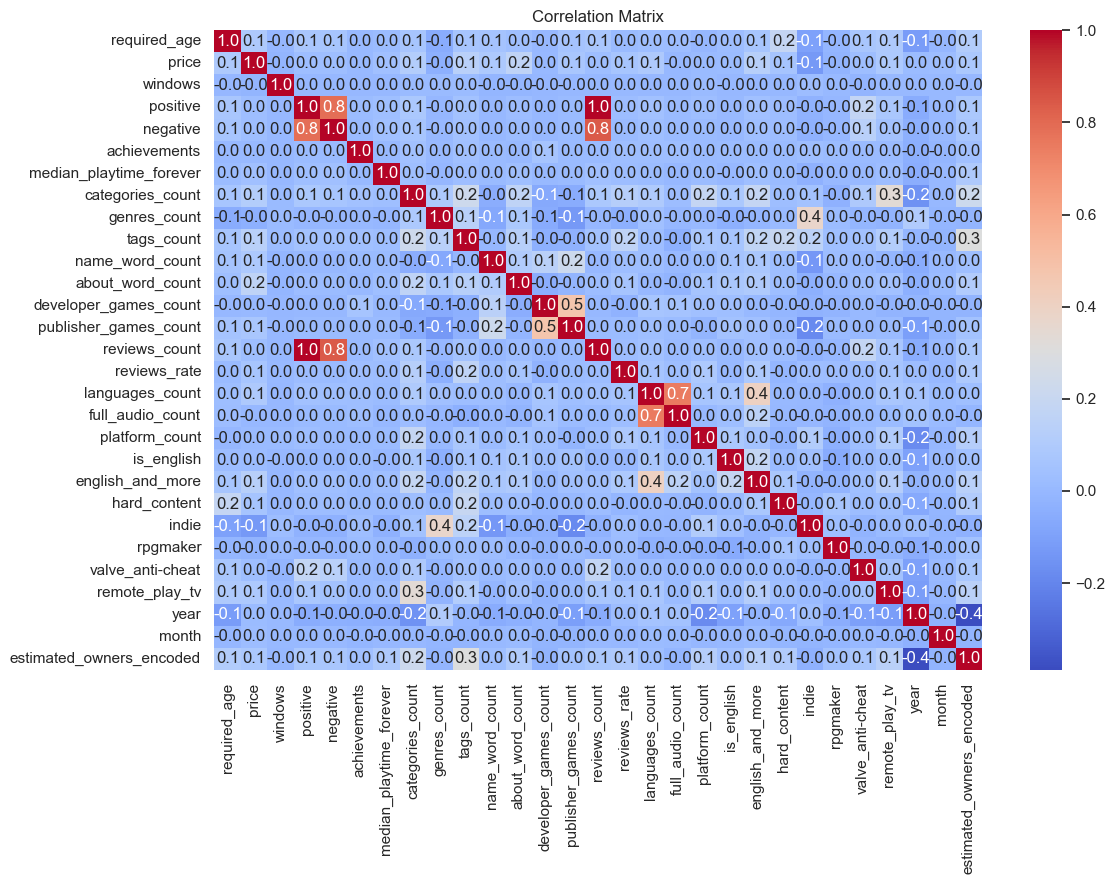

In [50]:
corr_matrix = data.corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

### Review Count (target)

In [88]:
round(data['reviews_count'].describe(), 2)

count      81151.00
mean        1170.47
std        28761.62
min            0.00
25%            1.00
50%           11.00
75%           69.00
max      6531097.00
Name: reviews_count, dtype: float64

In [52]:
fig = px.box(data, title='Distribution of reviews count using boxplot', x='reviews_count')
fig.show()

In [53]:
threshold = 5
x = data.loc[data['reviews_count'] <= threshold].shape[0]
percent = round((x / data.shape[0]) * 100)
print(f"Games equal or less than {threshold} reviews represent {percent}% of the dataset.") 

Games equal or less than 5 reviews represent 40% of the dataset.


In [54]:
x = data.loc[data['reviews_count'] == 0].shape[0]
percent = round((x / data.shape[0]) * 100)
print(f"Games with 0 reviews represent {percent}% of the dataset.") 

Games with 0 reviews represent 21% of the dataset.


In [55]:
fig = px.histogram(data, x='reviews_count', title='Distribution of reviews count using histplot (zoomed)', range_y=[0, 50], range_x=[0, 500000])
fig.show()

In [56]:
data_sum = data[['positive', 'negative']].sum()

fig = px.pie(values=data_sum, names=data_sum.index, title="Ratio of positive and negative games")
fig.show()

In [57]:
most_reviewed_games = data[['name', 'reviews_count']].sort_values(by='reviews_count', ascending=False).head(20)

fig = px.bar(most_reviewed_games, x='name', y='reviews_count', title='Most reviewed games')
fig.update_layout(xaxis_title='Name', yaxis_title='Reviews count')
fig.show()

### Release date

In [58]:
year_counts = data['year'].value_counts().sort_index()
fig = px.line(data_frame=year_counts, x=year_counts.index, y=year_counts.values, title='Number of games published in a given year')
fig.update_layout(xaxis_title='year', yaxis_title='games published')
fig.show()

In [103]:
fig = go.Figure()

years = [2023, 2022, 2021, 2020, 2019, 2018]

for y in years: 
    data_with_year = data.loc[data['year'] == y]
    month_counts = data_with_year['month'].value_counts().sort_index()
    fig.add_trace(go.Scatter(x=month_counts.index, y=month_counts.values, name=y, line_shape='linear'))

fig.update_traces(hoverinfo='text+name', mode='lines+markers')
fig.update_layout(xaxis_title='month', yaxis_title='games published', title='Number of published games for each month (different years)')
fig.show()

In [132]:
fig = go.Figure()

indie = data.loc[(data['indie'] == True) & data['year'].isin(years)]
not_indie = data.loc[(data['indie'] == False) & data['year'].isin(years)]

month_counts = indie['month'].value_counts().sort_index()
fig.add_trace(go.Scatter(x=month_counts.index, y=month_counts.values, name='indie', line_shape='linear'))

month_counts = not_indie['month'].value_counts().sort_index()
fig.add_trace(go.Scatter(x=month_counts.index, y=month_counts.values, name='not indie', line_shape='linear'))

fig.update_layout(xaxis_title='month', yaxis_title='games published', title='Number of games published in a given month (all years)')
fig.show()

### Categories

In [61]:
unique_categories.sort_values(by='count', ascending=False, inplace=True)

fig = px.bar(unique_categories, x='categories', y='count', title='Most popular Categories')
fig.update_layout(xaxis_title='category', yaxis_title='games')
fig.show()

In [149]:
category_stats_df = create_stats_df(unique_categories, text_feature='categories', target='reviews_count', min_count=1000).head(15)
category_stats_df

name  median   mean     std  count
19           Remote Play on TV     359  13853  150712   2159
6          Steam Trading Cards     267   6004   76402   9840
21              Steam Workshop     194  14544  166696   1836
23          Captions available      77   5599   44000   1182
17  Cross-Platform Multiplayer      59   5165   41252   2318
20       Includes level editor      56   5693   40956   1962
2                  Steam Cloud      48   2405   20630  18732
18            In-App Purchases      43  11162  150038   2277
22                         MMO      37   5202   36005   1280
13                Online Co-op      35   7268   51774   4439
15                       Stats      29   4937  117923   3569
9                   Online PvP      28   4868   45964   7001
10          Steam Leaderboards      28   1211    8474   6790
8                        Co-op      27   5240   45330   7775
4                 Multi-player      26   4107   64495  15517

In [200]:
show_feature_count_by_year(stats_df=category_stats_df, feature='categories')

In [201]:
category_stats_1 = create_stats_df(unique_categories, text_feature='categories', target='reviews_count', min_count=1000, year=2022)
category_stats_2 = create_stats_df(unique_categories, text_feature='categories', target='reviews_count', min_count=1000, year=2023)
category_stats_2['growth'] = ((category_stats_2['count'] - category_stats_1['count']) / category_stats_1['count']) * 100
category_stats_2['growth_abs'] = abs((category_stats_2['count'] - category_stats_1['count']) / category_stats_1['count']) * 100
category_stats_2.sort_values(by='growth_abs', ascending=False)

name  median  mean   std  count     growth  \
23          Captions available       1   295  1318     68 -21.839080   
19           Remote Play on TV       4   508  2988     86 -21.818182   
2                  Steam Cloud       4   304  3032   2922  18.491484   
6          Steam Trading Cards     160  1622  9171    206 -17.928287   
24                   (no info)       0     2     4    134  11.666667   
3      Full controller support       3   332  3247   2598  10.836177   
20       Includes level editor       1   263  2556    186  10.714286   
0                Single-player       0   107  1862  13307  10.651921   
5   Partial Controller Support       1   246  3381   1523  10.602760   
13                Online Co-op       0   636  4934    889  10.161090   
21              Steam Workshop       6   210   778    142  -9.554140   
1           Steam Achievements       2   214  2471   5411   8.003992   
17  Cross-Platform Multiplayer       0   827  4515    317   7.823129   
22                         MMO       0   351  2740    240   7.623318   
8                        Co-op       1   487  4232   1267   6.649832   
15                       Stats       2    53   338    332  -5.949008   
10          Steam Leaderboards       1    45   462    717   4.366812   
12         Shared/Split Screen       1   256  2353    734  -4.302477   
14     Shared/Split Screen PvP       1   251  2218    478  -4.016064   
4                 Multi-player       0   352  3387   2225   3.971963   
16   Shared/Split Screen Co-op       2   369  2997    410  -3.755869   
9                   Online PvP       0   331  2379   1062   2.312139   
18            In-App Purchases       0   505  3750    420   1.941748   
7                          PvP       0   246  2042   1448   0.765484   
11        Remote Play Together       1   264  2421    692  -0.574713   

    growth_abs  
23   21.839080  
19   21.818182  
2    18.491484  
6    17.928287  
24   11.666667  
3    10.836177  
20   10.714286  
0    10.651921  
5    10.602760  
13   10.161090  
21    9.554140  
1     8.003992  
17    7.823129  
22    7.623318  
8     6.649832  
15    5.949008  
10    4.366812  
12    4.302477  
14    4.016064  
4     3.971963  
16    3.755869  
9     2.312139  
18    1.941748  
7     0.765484  
11    0.574713

### Genres

In [65]:
unique_genres.sort_values(by='count', ascending=False, inplace=True)

fig = px.bar(unique_genres, x='genres', y='count', title='Most popular Genres')
fig.update_layout(xaxis_title='genre', yaxis_title='games')
fig.show()

In [66]:
genres_stats_df = create_stats_df(unique_genres, text_feature='genres', target='reviews_count', min_count=1000)
genres_stats_df

name  median  mean    std  count
11  Massively Multiplayer      27  4641  52416   2160
4              Simulation      15  1088  12451  16050
6                     RPG      15  1559  18773  14351
5                Strategy      14   985  16028  15501
3               Adventure      13  1095  18648  31272
0                   Indie      12   630  10488  56625
2                  Action      12  1930  43300  33599
9                  Sports      12   926  12824   3767
10                 Racing      11   839  11215   3073
1                  Casual       7   329   6551  34013
7            Early Access       7   551   7794  10331
8            Free to Play       7  3346  89082   6606

In [67]:
show_feature_count_by_year(stats_df=genres_stats_df, feature='genres')

In [218]:
category_stats_1 = create_stats_df(unique_genres, text_feature='genres', target='reviews_count', min_count=1000, year=2022)
category_stats_2 = create_stats_df(unique_genres, text_feature='genres', target='reviews_count', min_count=1000, year=2023)
category_stats_2['growth'] = ((category_stats_2['count'] - category_stats_1['count']) / category_stats_1['count']) * 100

In [219]:
category_stats_2.sort_values(by='growth', ascending=True)

name  median  mean   std  count     growth
8            Free to Play       0     3    58   1202  -4.905063
11  Massively Multiplayer       0   243  2248    358   1.994302
0                   Indie       0    71  1427   9372   7.526388
7            Early Access       0   154  2563   2440   9.270040
6                     RPG       0   227  3025   2714  10.459910
3               Adventure       0   144  2068   5671  11.130707
2                  Action       0   166  2166   5668  11.137255
5                Strategy       0    71   801   2724  11.502251
1                  Casual       0    28   516   6369  12.011959
9                  Sports       0   103  1201    649  16.726619
4              Simulation       0   102  1338   3009  17.493167
10                 Racing       0    30   259    592  17.693837

In [220]:
category_stats_2.sort_values(by='growth', ascending=False)

name  median  mean   std  count     growth
10                 Racing       0    30   259    592  17.693837
4              Simulation       0   102  1338   3009  17.493167
9                  Sports       0   103  1201    649  16.726619
1                  Casual       0    28   516   6369  12.011959
5                Strategy       0    71   801   2724  11.502251
2                  Action       0   166  2166   5668  11.137255
3               Adventure       0   144  2068   5671  11.130707
6                     RPG       0   227  3025   2714  10.459910
7            Early Access       0   154  2563   2440   9.270040
0                   Indie       0    71  1427   9372   7.526388
11  Massively Multiplayer       0   243  2248    358   1.994302
8            Free to Play       0     3    58   1202  -4.905063

### Tags

In [68]:
unique_tags.sort_values(by='count', ascending=False, inplace=True)

fig = px.bar(unique_tags, x='tags', y='count', title='Most popular Tags')
fig.update_layout(xaxis_title='tag', yaxis_title='games')
fig.show()

In [69]:
tags_stats_df = create_stats_df(unique_tags, text_feature='tags', target='reviews_count', min_count=100)

In [70]:
tags_stats_df.head(20)

name  median   mean     std  count
377                  Epic     670  12783   37278    112
209              Moddable     568  24758  252555    728
296          Cult Classic     546   2262    4777    313
256                MMORPG     522   8486   36002    426
285                Remake     503   6377   22866    339
340           Kickstarter     500   3622   12797    190
354             Nostalgia     412   3137   16043    166
39       Great Soundtrack     396   6620   35759   4447
131               Classic     324   3994   15277   1547
300  Real-Time with Pause     310   5675   21863    284
359              Episodic     310   5118   15611    149
220            Soundtrack     304   6035   34023    632
346   Villain Protagonist     299   1845    4409    183
380           Crowdfunded     239   3497   12726    101
49                  Co-op     202  12733  124646   3926
157                Mature     200   6552   53624   1206
96           Online Co-Op     195  17411  165548   2140
317        Touch-Friendly     193   3026   14130    251
292                    4X     193   3658   19717    326
206                Hentai     190   1704    8657    772

In [71]:
show_feature_count_by_year(stats_df=tags_stats_df.sort_values(by='count', ascending=False), feature='tags')

In [72]:
show_feature_count_by_year(stats_df=tags_stats_df.sort_values(by='median', ascending=False), feature='tags')

In [208]:
category_stats_1 = create_stats_df(unique_tags, text_feature='tags', target='reviews_count', min_count=1000, year=2022)
category_stats_2 = create_stats_df(unique_tags, text_feature='tags', target='reviews_count', min_count=1000, year=2023)
category_stats_2['growth'] = ((category_stats_2['count'] - category_stats_1['count']) / category_stats_1['count']) * 100

In [209]:
category_stats_2.sort_values(by='growth', ascending=True).head(10)

name  median  mean   std  count     growth
131                Classic     102   318   473      8 -61.904762
163                 Flight       6    70   305    104 -46.666667
137               RPGMaker      10   242  1300     50 -40.476190
45            Free to Play      10   622  2615     32 -38.461538
122  Massively Multiplayer      15  1067  4788     64 -36.000000
164           Experimental       7    47   132     41 -35.937500
171               Fighting      17  1451  5501     47 -35.616438
141                Clicker       7    52   179    205 -33.224756
77                  Nudity      18   152   739    174 -33.076923
34                      VR       4    47   235    244 -30.878187

In [211]:
category_stats_2.sort_values(by='growth', ascending=False).head(10)

name  median  mean   std  count     growth
6            (no info)       0     0     0   7618  42.846428
103  Walking Simulator       8    84   448    368  18.327974
113   Action Roguelike       8   138  1090    497  12.443439
94         Bullet Hell       7    80   341    408  12.396694
146            VR Only       3    21    69    108  11.340206
124             Nature       5    57   294    399  10.220994
68          Rogue-like       8   166  1065    626  10.017575
173           Thriller       9    63   174    244   8.928571
81          Rogue-lite      11   134   543    580   5.839416
166           Life Sim      12    97   268    278   2.583026

### Different categories, genres, tags correlations

In [73]:
def print_correlation(unique_df, feature='genres', target='reviews_count', threshold=0.1):
    df_for_corr = data.copy()
    for val in unique_df[feature].values:

        mask = data[feature].str.contains(val, case=False)
        df_for_corr[val] = mask
        
        correlation = df_for_corr[val].corr(df_for_corr[target])
        if abs(correlation) >= threshold:
            print(f'{target} and {val}: {correlation}')

In [74]:
print_correlation(unique_categories, feature='categories', target='reviews_count')
print_correlation(unique_genres, feature='genres', target='reviews_count')
print_correlation(unique_tags, feature='tags', target='reviews_count')

reviews_count and Remote Play on Tablet: 0.17963433882833105
reviews_count and Remote Play on Phone: 0.14890006442245976
reviews_count and Valve Anti-Cheat enabled: 0.17605597588264674


In [75]:
def create_attr_df(unique_df, feature='genres'):
    df_for_corr = data.copy()
    for val in unique_df[feature].values:

        mask = data[feature].str.contains(val, case=False)
        df_for_corr[val] = mask
        
    return df_for_corr[unique_df[feature].values]

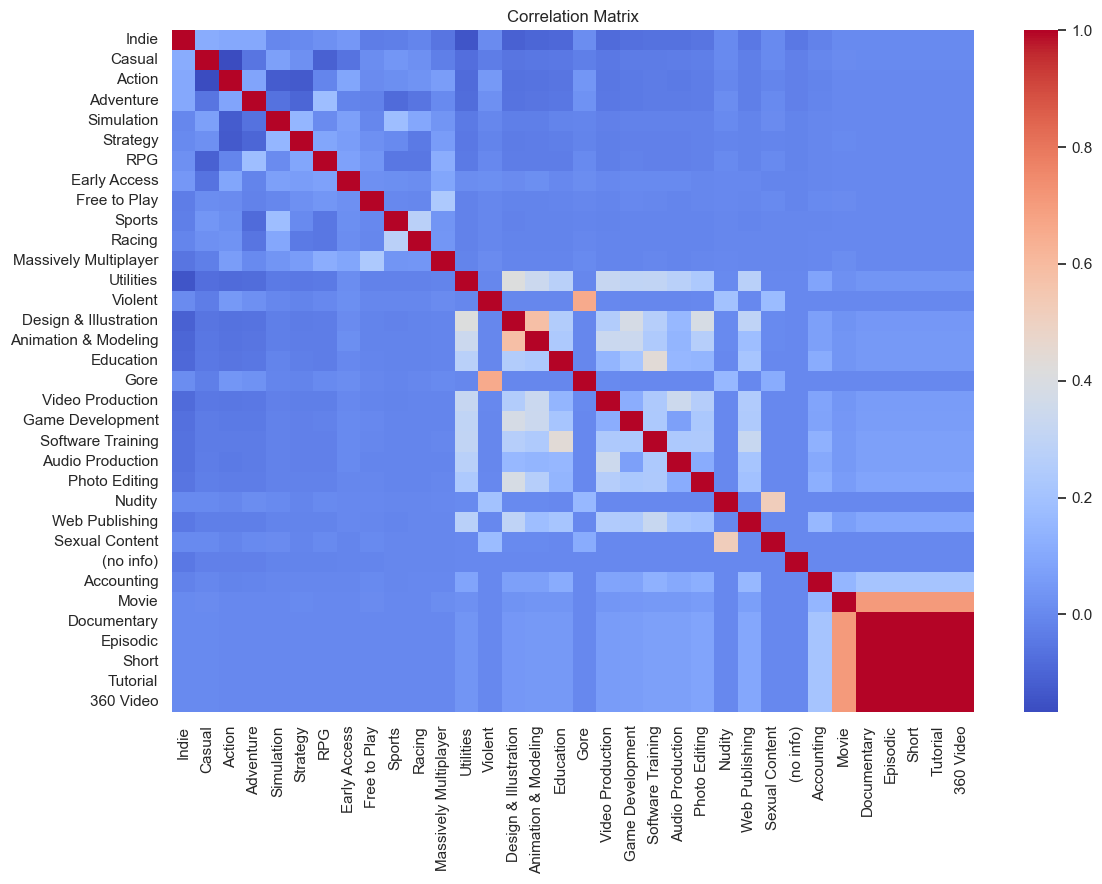

In [76]:
genres_corr_df = create_attr_df(unique_genres, 'genres')
corr_matrix = genres_corr_df.corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.1f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

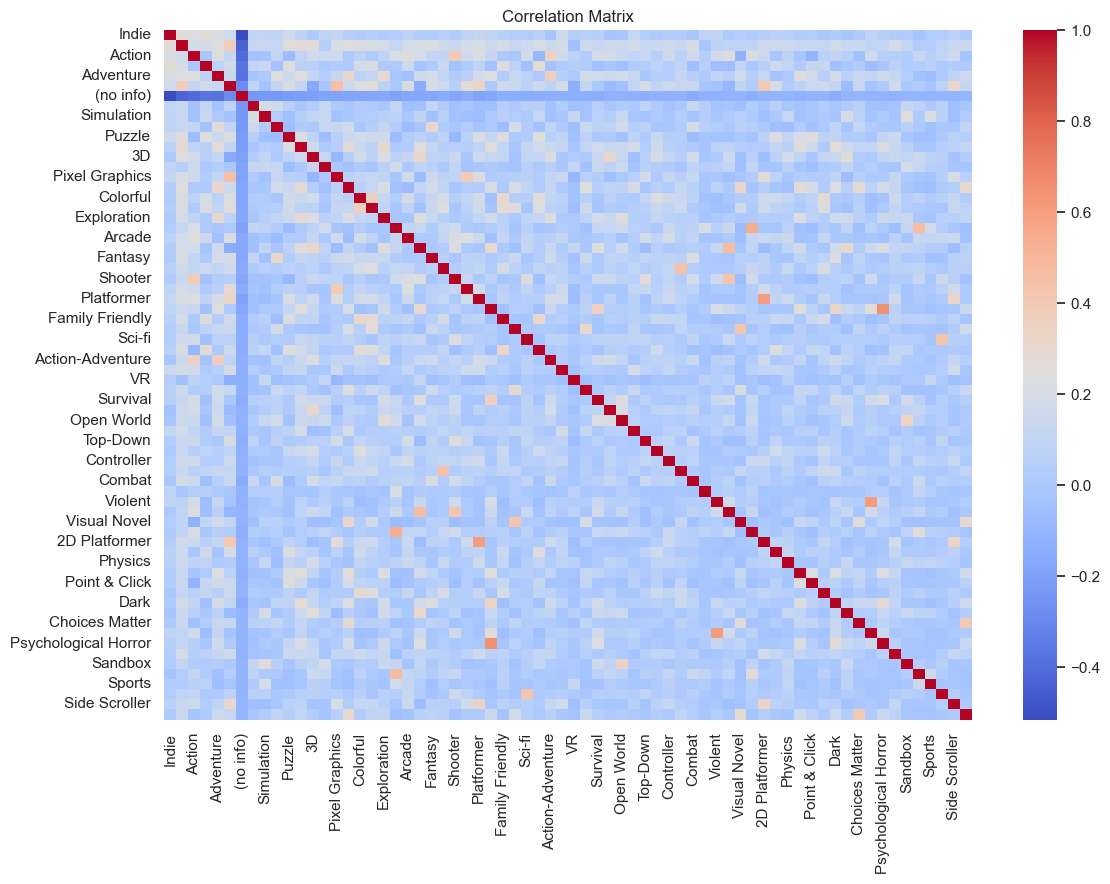

In [77]:
tags_corr_df = create_attr_df(unique_tags.loc[unique_tags['count'] > 3000], 'tags')
corr_matrix = tags_corr_df.corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.1f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [78]:
genres_corr_df = create_attr_df(unique_genres, 'genres')

### Name 

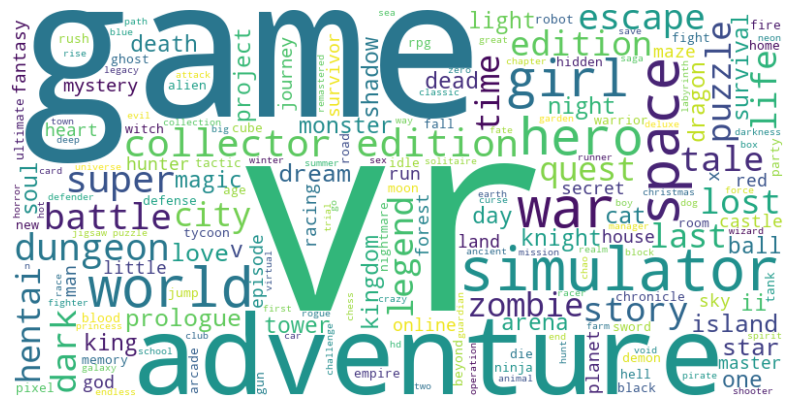

In [79]:
all_words = ' '.join(data['name_cleaned'])
create_word_cloud(all_words)

### About

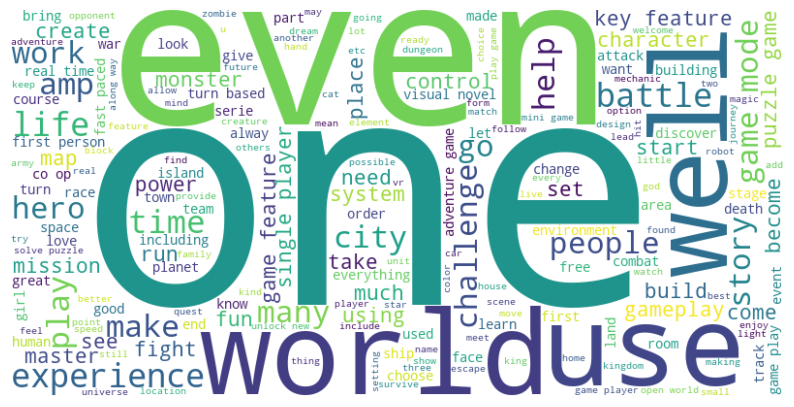

In [80]:
all_words = ' '.join(data['about_cleaned'])
create_word_cloud(all_words)

### Languages 

In [81]:
age_counts = data['languages_count'].value_counts().reset_index()
age_counts.columns = ['languages_count', 'count']
fig = px.bar(age_counts, x='languages_count', y='count', title='Number of languages')
fig.show()

In [82]:
all_size = data.shape[0]
en_size = data.loc[data['is_english']].shape[0]
only_en_size = data.loc[data['is_english'] & (data['languages_count'] == 1)].shape[0]
en_and_more_size = data.loc[data['is_english'] & (data['languages_count'] > 1)].shape[0]

In [83]:
custom_colors = ['#1f77b4', '#ff7f0e']

In [84]:
fig = px.pie(values=[en_size, all_size - en_size], names=['english supported', 'enlish not supported'], title="Games with English support", color_discrete_sequence=custom_colors)
fig.show()

In [85]:
fig = px.pie(values=[only_en_size, all_size - only_en_size], names=['only english supported', 'rest of games'], title="Games with support only for English", color_discrete_sequence=custom_colors)
fig.show()

In [86]:
custom_colors_map = {
    'english and more languages supported': '#1f77b4',
    'rest of games': '#ff7f0e'
}

df = pd.DataFrame({'names': custom_colors_map.keys(), 'colors': custom_colors_map.values()})
fig = go.Figure(data=[go.Pie(labels=df['names'], 
                             values=[en_and_more_size, all_size - en_and_more_size], 
                             marker=dict(colors=df['colors']))])

fig.update_layout(title="Games with support for English and more languages")
fig.show()

### Indie and genres_count

In [87]:
no_indie_genres_count = data.loc[data['indie'] == False]['genres_count'].value_counts()
indie_genres_count = data.loc[data['indie'] == True]['genres_count'].value_counts()

combined_data = pd.concat([no_indie_genres_count, indie_genres_count], axis=1)
combined_data.columns = ['no indie', 'indie']

fig = px.bar(combined_data, x=combined_data.index, y=combined_data.columns, 
             barmode='group', title='Most common number of genres combined with indie variable')

fig.update_layout(xaxis_title='number of genres', yaxis_title='games')
fig.show()

## Summary

### Conclusions 
- Usually there is small number of published games in: **January, February, June**. This agrees with opinions I have read in Internet. These months can be quite good for releasing a game with had small budget for marketing. The most games are release in **October**. This makes sense. Summer ends and we have more time for playing on rainy evenings. 
- But what is interesting - games without the tag 'indie' did not have the drop of publishments in **June**. They more often had a drop in **April**.
- Indie games are usually described by more genres. Maybe this come from the fact that usually indie developers want to be more innovative. Or maybe they want to be more visible in steam search engine, because of often small budget for marketing. 

### What I have learned? 
- In this project I used Plotly first time and it is realy fantastic!  
- Number of reviews is not the best solution for measuring the popularity of the game. For example, a good selling game sometimes can lack in interests of reviewers. 